In [1]:
import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings 
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn import preprocessing
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking
from sklearn.metrics import balanced_accuracy_score
import os
import joblib
sn.set(color_codes=True)
from numpy.random import seed
import tensorflow as tf
tf.compat.v1.logging
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

2022-11-24 09:36:19.741550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_1 = pd.read_excel('test_set_thesis.xlsx', sheet_name='Sheet1')
df_2 = pd.read_excel('Thesis_range_month3.xlsx', sheet_name='Sheet1')

In [7]:
df_1=df_1.rename(columns = {".KNG-P-PL1-PRO-PEE-110-020-E001-ALARM": "alarm", 
                       ".KNG-P-PL1-PRO-PEE-110-020-E001-GEM": "avg_el_usage",
                      ".KNG-P-PL1-PRO-PEE-110-020-E001-PV":"ex_el_usage",
                      ".KNG-P-PL1-ODB-LINERATE-MOM-PV":"line_rate"}) 

df_2=df_2.rename(columns = {".KNG-P-PL1-PRO-PEE-110-020-E001-ALARM": "alarm", 
                       ".KNG-P-PL1-PRO-PEE-110-020-E001-GEM": "avg_el_usage",
                      ".KNG-P-PL1-PRO-PEE-110-020-E001-PV":"ex_el_usage",
                      ".KNG-P-PL1-ODB-LINERATE-MOM-PV":"line_rate"})

df_1["TimeStamp"] = pd.to_datetime(df_1["TimeStamp"])
df_1['TimeStamp']

df_2["TimeStamp"] = pd.to_datetime(df_2["TimeStamp"])
df_2['TimeStamp']

print(df_1.isnull().values.any())
print('----')
print(df_1.describe())

print(df_2.isnull().values.any())
print('----')
print(df_2.describe())

df_1['line_rate_ma'] = df_1['line_rate'].rolling(15, min_periods=1).mean()
df_1
df_2['line_rate_ma'] = df_2['line_rate'].rolling(15, min_periods=1).mean()
df_2

df_1['alarm']=df_1['alarm'].astype(int)
alarm_bool=df_1[df_1.columns[1]].astype(bool)
df_1['alarm'] = alarm_bool

df_2['alarm']=df_2['alarm'].astype(int)
alarm_bool=df_2[df_2.columns[1]].astype(bool)
df_2['alarm'] = alarm_bool

False
----
       avg_el_usage   ex_el_usage     line_rate  line_rate_ma
count  44001.000000  44001.000000  44001.000000  44001.000000
mean      22.566744     22.544710     22.177390     22.177212
std       11.394883     12.877722     11.878702     11.641150
min        0.000000      0.000000      0.000000      0.000000
25%       21.605797     19.021954     18.962309     18.952850
50%       26.754274     24.017889     27.901842     27.923659
75%       29.594122     31.123943     30.013128     29.969950
max       45.761646    127.000000    116.307686     38.803015
False
----
       avg_el_usage   ex_el_usage     line_rate  line_rate_ma
count  43998.000000  43998.000000  43998.000000  43998.000000
mean      32.199339     32.194336     26.095328     26.094688
std       11.277856     14.213025      7.823686      7.394089
min        0.000000      0.000000      0.000000      0.000000
25%       28.361170     23.702448     27.076160     26.989489
50%       32.205420     31.551091     28.011532 

In [15]:
df_1['status']='Working'

In [16]:
# Creation of the line rate status variable

def compute_status (row):
    if df_1.loc[df_1.index[row], "line_rate_ma"] == 0 and df_1.loc[df_1.index[row - 10], "avg_el_usage"] > 0:
        df_1.loc[df_1.index[row], "status"] = 'Failure'
    elif df_1.loc[df_1.index[row], "line_rate_ma"] == 0 and df_1.loc[df_1.index[row - 10], "avg_el_usage"] == 0:
        df_1.loc[df_1.index[row], "status"] = 'Shutdown' 
    else:
        df_1.loc[df_1.index[row], "status"] = 'Working'

for ind in range(10, len(df_1.index)):
    compute_status(ind)

In [17]:
# Creation of of the forward 30 minutes status of the line rate

df_1["status_30min"] = 'Unknown'

for ind in range(0, len(df_1.index) - 60):
    df_1.loc[df_1.index[ind], "status_30min"] = df_1.loc[df_1.index[ind + 60], "status"]

In [18]:
# Creation of the Renaining Useful Life variable

#set default time to 1 row
df_1["rul"] = 1

#set time to failure to 0 for all rows where failure is true
df_1.loc[df_1["status"]=="Failure", "rul"] = 0

#loop backwards over rows if one row down and the row itself are not failure set time to the time one row down + 1
for row in range(len(df_1) -2, 0, -1):
    if not df_1.loc[row + 1, "rul"] == 0 and not df_1.loc[row, "rul"] == 0:
        df_1.loc[row, "rul"] = df_1.loc[row + 1, "rul"] + 1

df_1 = df_1.loc[1:,]
df_1["rul"] = df_1["rul"] / 0.5

df_1.head()

,TimeStamp,alarm,avg_el_usage,ex_el_usage,line_rate,line_rate_ma,status,rul,rul_bins,status_30min
1,2021-06-07 11:50:30,False,27.595509,20.128948,31.720282,31.799395,Working,4326.0,24hours+,Working
2,2021-06-07 11:51:00,False,27.906555,37.788853,31.720282,31.773024,Working,4324.0,24hours+,Working
3,2021-06-07 11:51:30,False,29.648663,31.675674,31.720282,31.759838,Working,4322.0,24hours+,Working
4,2021-06-07 11:52:00,False,27.922028,21.147259,31.720282,31.751927,Working,4320.0,24hours+,Working
5,2021-06-07 11:52:30,False,27.754829,30.325830,31.868921,31.771426,Working,4318.0,24hours+,Working


In [19]:
# Creation of RUL time bins for classification

df_1["rul_bins"] = "unknown"

bin1_mask = df_1["rul"] < 30
df_1.loc[bin1_mask, "rul_bins"] = "30mins"

bin2_mask = (df_1["rul"] >= 30) & (df_1["rul"] < 60)
df_1.loc[bin2_mask, "rul_bins"] = "60mins"

bin2_mask = (df_1["rul"] >= 60) & (df_1["rul"] < 180)
df_1.loc[bin2_mask, "rul_bins"] = "3hours"

bin3_mask = (df_1["rul"] >= 180) & (df_1["rul"] < 720)
df_1.loc[bin3_mask, "rul_bins"] = "12hours"

bin4_mask = (df_1["rul"] >= 720) & (df_1["rul"] < 1440)
df_1.loc[bin4_mask, "rul_bins"] = "24hours"

bin5_mask = (df_1["rul"] >= 1440)
df_1.loc[bin5_mask, "rul_bins"] = "24hours+"

In [20]:
df_2['status']='Working'

In [21]:
# Creation of the line rate status variable

def compute_status (row):
    if df_2.loc[df_2.index[row], "line_rate_ma"] == 0 and df_2.loc[df_1.index[row - 10], "avg_el_usage"] > 0:
        df_2.loc[df_2.index[row], "status"] = 'Failure'
    elif df_2.loc[df_2.index[row], "line_rate_ma"] == 0 and df_2.loc[df_1.index[row - 10], "avg_el_usage"] == 0:
        df_2.loc[df_2.index[row], "status"] = 'Shutdown' 
    else:
        df_2.loc[df_2.index[row], "status"] = 'Working'

for ind in range(10, len(df_2.index)):
    compute_status(ind)

In [22]:
# Creation of of the forward 30 minutes status of the line rate

df_2["status_30min"] = 'Unknown'

for ind in range(0, len(df_2.index) - 60):
    df_2.loc[df_2.index[ind], "status_30min"] = df_2.loc[df_2.index[ind + 60], "status"]

In [23]:
# Creation of the Renaining Useful Life variable

#set default time to 1 row
df_2["rul"] = 1

#set time to failure to 0 for all rows where failure is true
df_2.loc[df_2["status"]=="Failure", "rul"] = 0

#loop backwards over rows if one row down and the row itself are not failure set time to the time one row down + 1
for row in range(len(df_2) -2, 0, -1):
    if not df_2.loc[row + 1, "rul"] == 0 and not df_2.loc[row, "rul"] == 0:
        df_2.loc[row, "rul"] = df_2.loc[row + 1, "rul"] + 1

df_2 = df_2.loc[1:,]
df_2["rul"] = df_2["rul"] / 0.5

df_2.head()

,TimeStamp,alarm,avg_el_usage,ex_el_usage,line_rate,line_rate_ma,status,status_30min,rul
1,2021-07-07 11:51:30,False,22.609907,31.674854,19.594288,19.594288,Working,Working,6320.0
2,2021-07-07 11:52:00,False,26.933184,20.201208,19.594288,19.594288,Working,Working,6318.0
3,2021-07-07 11:52:30,False,28.904484,39.827011,19.594288,19.594288,Working,Working,6316.0
4,2021-07-07 11:53:00,False,30.583208,25.773729,19.594288,19.594288,Working,Working,6314.0
5,2021-07-07 11:53:30,False,27.189575,27.254736,27.804878,20.962720,Working,Working,6312.0


In [24]:
# Creation of RUL time bins for classification

df_1["rul_bins"] = "unknown"

bin1_mask = df_2["rul"] < 30
df_2.loc[bin1_mask, "rul_bins"] = "30mins"

bin2_mask = (df_2["rul"] >= 30) & (df_1["rul"] < 60)
df_2.loc[bin2_mask, "rul_bins"] = "60mins"

bin2_mask = (df_2["rul"] >= 60) & (df_1["rul"] < 180)
df_2.loc[bin2_mask, "rul_bins"] = "3hours"

bin3_mask = (df_2["rul"] >= 180) & (df_1["rul"] < 720)
df_2.loc[bin3_mask, "rul_bins"] = "12hours"

bin4_mask = (df_2["rul"] >= 720) & (df_1["rul"] < 1440)
df_2.loc[bin4_mask, "rul_bins"] = "24hours"

bin5_mask = (df_2["rul"] >= 1440)
df_2.loc[bin5_mask, "rul_bins"] = "24hours+"

In [25]:
#Encode labels

label_encoder = preprocessing.LabelEncoder()
df_1['status']= label_encoder.fit_transform(df_1['status'])
print(df_1.head())

#Encode labels

label_encoder = preprocessing.LabelEncoder()
df_2['status']= label_encoder.fit_transform(df_2['status'])
print(df_2.head())

            TimeStamp  alarm  avg_el_usage  ex_el_usage  line_rate  \
1 2021-06-07 11:50:30  False     27.595509    20.128948  31.720282   
2 2021-06-07 11:51:00  False     27.906555    37.788853  31.720282   
3 2021-06-07 11:51:30  False     29.648663    31.675674  31.720282   
4 2021-06-07 11:52:00  False     27.922028    21.147259  31.720282   
5 2021-06-07 11:52:30  False     27.754829    30.325830  31.868921   

   line_rate_ma  status     rul rul_bins status_30min  
1     31.799395       2  4326.0  unknown      Working  
2     31.773024       2  4324.0  unknown      Working  
3     31.759838       2  4322.0  unknown      Working  
4     31.751927       2  4320.0  unknown      Working  
5     31.771426       2  4318.0  unknown      Working  
            TimeStamp  alarm  avg_el_usage  ex_el_usage  line_rate  \
1 2021-07-07 11:51:30  False     22.609907    31.674854  19.594288   
2 2021-07-07 11:52:00  False     26.933184    20.201208  19.594288   
3 2021-07-07 11:52:30  False     

In [26]:
df_1.drop(df_1[df_1['status_30min'] == 'Unknown'].index, inplace = True)
df_1
df_2.drop(df_2[df_2['status_30min'] == 'Unknown'].index, inplace = True)
df_2

,TimeStamp,alarm,avg_el_usage,ex_el_usage,line_rate,line_rate_ma,status,status_30min,rul,rul_bins
1,2021-07-07 11:51:30,False,22.609907,31.674854,19.594288,19.594288,2,Working,6320.0,24hours+
2,2021-07-07 11:52:00,False,26.933184,20.201208,19.594288,19.594288,2,Working,6318.0,24hours+
3,2021-07-07 11:52:30,False,28.904484,39.827011,19.594288,19.594288,2,Working,6316.0,24hours+
4,2021-07-07 11:53:00,False,30.583208,25.773729,19.594288,19.594288,2,Working,6314.0,24hours+
5,2021-07-07 11:53:30,False,27.189575,27.254736,27.804878,20.962720,2,Working,6312.0,24hours+
...,...,...,...,...,...,...,...,...,...,...
43933,2021-07-22 17:57:30,False,40.991486,28.753546,24.963505,25.090081,2,Working,130.0,3hours
43934,2021-07-22 17:58:00,False,32.878632,42.906597,24.963505,25.093498,2,Working,128.0,3hours
43935,2021-07-22 17:58:30,False,41.421127,34.703617,24.963505,25.081680,2,Working,126.0,3hours
43936,2021-07-22 17:59:00,False,34.724987,31.242062,24.655739,25.049345,2,Working,124.0,3hours


In [27]:
X=df_1[['alarm'] + ['avg_el_usage'] + ['ex_el_usage'] + ['line_rate_ma'] + ['status']]
y=df_1['status_30min']

X_2=df_2[['alarm'] + ['avg_el_usage'] + ['ex_el_usage'] + ['line_rate_ma'] + ['status']]
y_2=df_2['status_30min']

In [28]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

label_encoder = LabelEncoder()
y_2 = label_encoder.fit_transform(y_2)

In [29]:
#Train-test split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42,stratify= y)

In [30]:
smt = SMOTETomek(random_state=42)
X_train_2, y_train_2 = smt.fit_resample(X_train, y_train)

smt = SMOTETomek(random_state=42)
X_2, y_2 = smt.fit_resample(X_2,y_2)

## Logistic Regression

In [31]:
clf = LogisticRegression()
# training the model
clf.fit(X_train_2, y_train_2)

LogisticRegression()

In [32]:
regularized_lr=LogisticRegression(penalty='l2',solver='newton-cg',max_iter=200)
regularized_lr.fit(X_train_2,y_train_2)
y_pred=regularized_lr.predict(X_2)

In [33]:
accuracy_logreg= accuracy_score(y_2, y_pred)
print("Accuracy: {:.2f}%".format(accuracy_logreg * 100))
recall_logreg = recall_score(y_2, y_pred, average='weighted')
print("Recall: {:.2f}%".format(recall_logreg * 100))
precision_logreg=precision_score(y_2,y_pred, average='weighted')
print("Precision: {:.2f}%".format(precision_logreg * 100))
f1_logreg=f1_score(y_2, y_pred, average='weighted')
print("F1-Score: {:.2f}%".format(f1_logreg * 100))

Accuracy: 55.23%
Recall: 55.23%
Precision: 49.86%
F1-Score: 46.34%


In [35]:
print(classification_report(y_2, y_pred))
print(balanced_accuracy_score(y_2, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.03      0.06     40922
           1       0.69      0.67      0.68     40369
           2       0.50      0.96      0.65     40280

    accuracy                           0.55    121571
   macro avg       0.50      0.55      0.47    121571
weighted avg       0.50      0.55      0.46    121571

0.5549787440122677


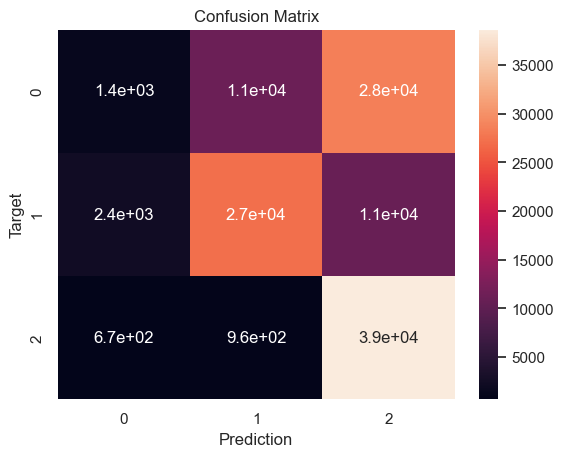

In [36]:
cf = confusion_matrix(y_2, y_pred)
plt.figure()
sn.heatmap(cf, annot=True)
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Confusion Matrix')
plt.savefig('cf.png', bbox_inches='tight')
plt.show()

## DT

In [37]:
# Wrapper function for making computations on the recall score for failures


def recall_failure(y_true, y_pred):

    wanted_labels = [0]
    wanted_indices = np.where(y_true == 0)
    wanted_y_true = y_true[wanted_indices]
    wanted_y_pred = y_pred[wanted_indices]
    recall_ = recall_score(y_true=wanted_y_true, y_pred=wanted_y_pred, average=None)[0]

    return recall_

In [42]:
# Test another tree's depth = range 1,6

recall_0_scorer = make_scorer(recall_failure)

pipe = Pipeline(steps=[("scaler", StandardScaler()), 
                    ("tree", DecisionTreeClassifier())])

param_grid = {
    "tree__max_depth" : range(1, 6)       # <- 6 is the best!
}

search = GridSearchCV(pipe, param_grid, return_train_score=True, scoring=recall_0_scorer, verbose=1)
search.fit(X_train_2, y_train_2)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

search_results_1 = pd.DataFrame(search.cv_results_)

y_pred_search = search.predict(X_2)

accuracy_DT= accuracy_score(y_2, y_pred_search)
print("Accuracy: {:.2f}%".format(accuracy_DT * 100))
recall_DT= recall_score(y_2, y_pred_search, average='weighted')
print("Recall: {:.2f}%".format(recall_DT * 100))
precision_DT=precision_score(y_2, y_pred_search, average='weighted')
print("Precision: {:.2f}%".format(precision_DT * 100))
f1_DT=f1_score(y_2, y_pred_search, average='weighted')
print("F1-Score: {:.2f}%".format(f1_DT * 100))

print(classification_report(y_2, y_pred_search))
print(balanced_accuracy_score(y_2, y_pred_search))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameter (CV score=0.812):
{'tree__max_depth': 5}
Accuracy: 64.49%
Recall: 64.49%
Precision: 64.52%
F1-Score: 64.21%
              precision    recall  f1-score   support

           0       0.58      0.51      0.54     40922
           1       0.73      0.67      0.70     40369
           2       0.63      0.76      0.69     40280

    accuracy                           0.64    121571
   macro avg       0.65      0.65      0.64    121571
weighted avg       0.65      0.64      0.64    121571

0.6456483123174314


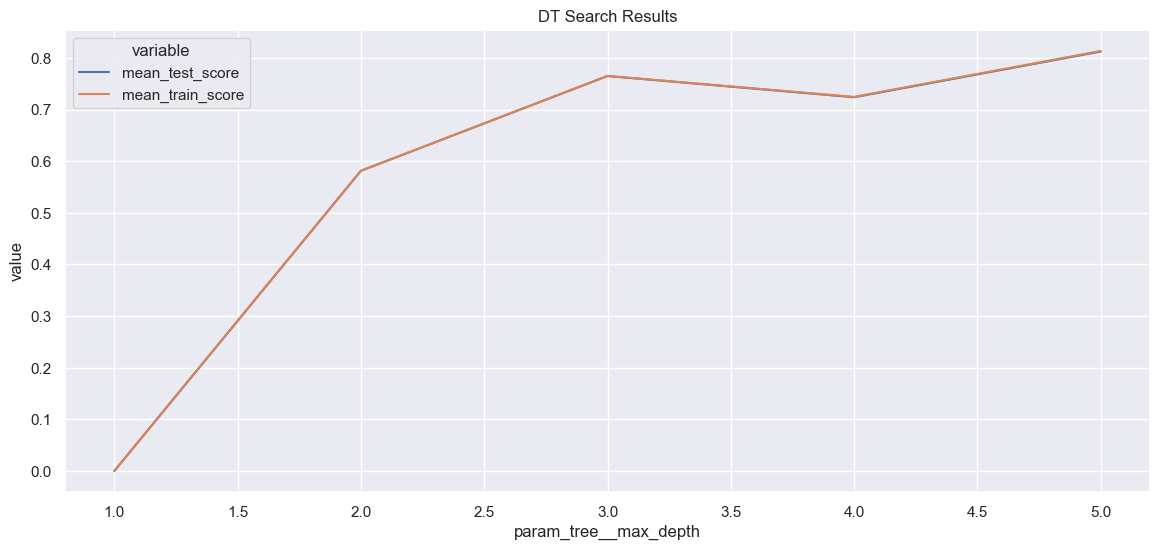

In [43]:
#melt dataframe into long format for seaborn to plot
search_long_1 = search_results_1.melt(id_vars=["param_tree__max_depth"], value_vars=["mean_test_score", "mean_train_score"])

#seaborn plot
plt.figure(figsize=(14, 6))
g = sn.lineplot(data=search_long_1, x="param_tree__max_depth", y="value", hue="variable").set(title='DT Search Results')

## RF

In [45]:
from sklearn.ensemble import RandomForestClassifier

recall_0_scorer = make_scorer(recall_failure)

pipe = Pipeline(steps=[("scaler", StandardScaler()), 
                    ("tree", RandomForestClassifier())])

param_grid = {
    "tree__max_depth" : range(1, 5),
    "tree__n_estimators" : [100]
}

search = GridSearchCV(pipe, param_grid, return_train_score=True, scoring=recall_0_scorer, verbose=1)
search.fit(X_train_2, y_train_2)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

search_results_2 = pd.DataFrame(search.cv_results_)

y_pred_search = search.predict(X_2)

accuracy_DT= accuracy_score(y_2, y_pred_search)
print("Accuracy: {:.2f}%".format(accuracy_DT * 100))
recall_DT= recall_score(y_2, y_pred_search, average='weighted')
print("Recall: {:.2f}%".format(recall_DT * 100))
precision_DT=precision_score(y_2, y_pred_search, average='weighted')
print("Precision: {:.2f}%".format(precision_DT * 100))
f1_DT=f1_score(y_2, y_pred_search, average='weighted')
print("F1-Score: {:.2f}%".format(f1_DT * 100))

print(classification_report(y_2, y_pred_search))
print(balanced_accuracy_score(y_2, y_pred_search))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameter (CV score=0.723):
{'tree__max_depth': 4, 'tree__n_estimators': 100}
Accuracy: 58.83%
Recall: 58.83%
Precision: 59.57%
F1-Score: 55.84%
              precision    recall  f1-score   support

           0       0.54      0.23      0.32     40922
           1       0.73      0.69      0.71     40369
           2       0.52      0.85      0.64     40280

    accuracy                           0.59    121571
   macro avg       0.60      0.59      0.56    121571
weighted avg       0.60      0.59      0.56    121571

0.5900848957343431


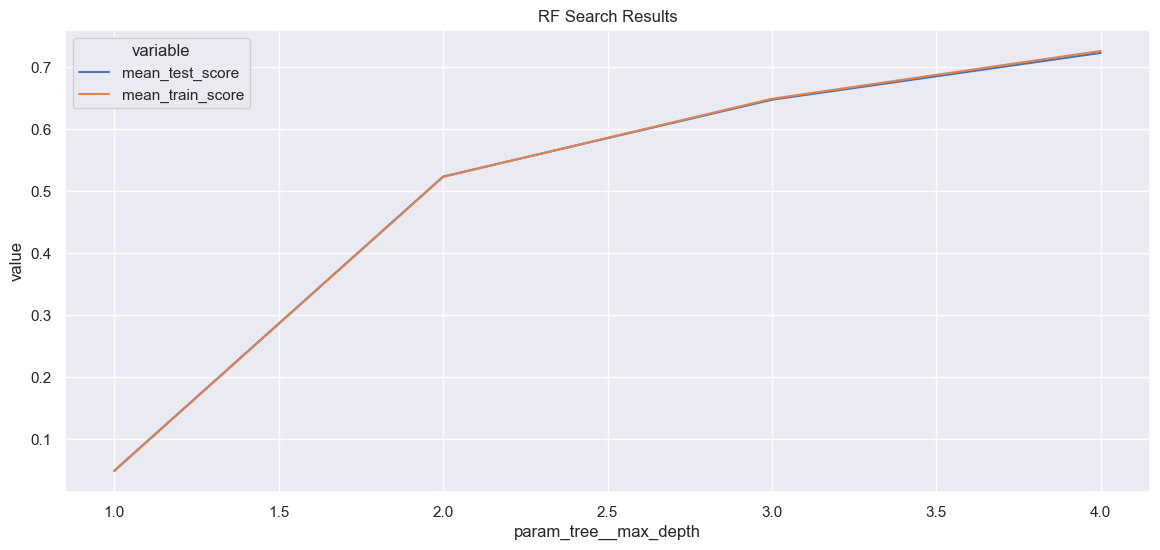

In [46]:
#melt dataframe into long format for seaborn to plot
search_long_2 = search_results_2.melt(id_vars=["param_tree__max_depth"], value_vars=["mean_test_score", "mean_train_score"])

#seaborn plot
plt.figure(figsize=(14, 6))
g_2 = sn.lineplot(data=search_long_2, x="param_tree__max_depth", y="value", hue="variable").set(title='RF Search Results')

## ET 

In [47]:
recall_0_scorer = make_scorer(recall_failure)

pipe = Pipeline(steps=[("scaler", StandardScaler()), 
                    ("tree", ExtraTreesClassifier())])

param_grid = {
    "tree__max_depth" : range(1, 3),
    "tree__n_estimators" : [1000]
}

search = GridSearchCV(pipe, param_grid, return_train_score=True, scoring=recall_0_scorer, verbose=1)
search.fit(X_train_2, y_train_2)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

search_results_3 = pd.DataFrame(search.cv_results_)

y_pred_search = search.predict(X_2)
accuracy_DT= accuracy_score(y_2, y_pred_search)
print("Accuracy: {:.2f}%".format(accuracy_DT * 100))
recall_DT= recall_score(y_2, y_pred_search, average='weighted')
print("Recall: {:.2f}%".format(recall_DT * 100))
precision_DT=precision_score(y_2, y_pred_search, average='weighted')
print("Precision: {:.2f}%".format(precision_DT * 100))
f1_DT=f1_score(y_2, y_pred_search, average='weighted')
print("F1-Score: {:.2f}%".format(f1_DT * 100))

print(classification_report(y_2, y_pred_search))
print(balanced_accuracy_score(y_2, y_pred_search))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameter (CV score=0.307):
{'tree__max_depth': 2, 'tree__n_estimators': 1000}
Accuracy: 55.71%
Recall: 55.71%
Precision: 51.03%
F1-Score: 46.19%
              precision    recall  f1-score   support

           0       0.36      0.03      0.05     40922
           1       0.67      0.68      0.68     40369
           2       0.50      0.97      0.66     40280

    accuracy                           0.56    121571
   macro avg       0.51      0.56      0.46    121571
weighted avg       0.51      0.56      0.46    121571

0.5597793636932876


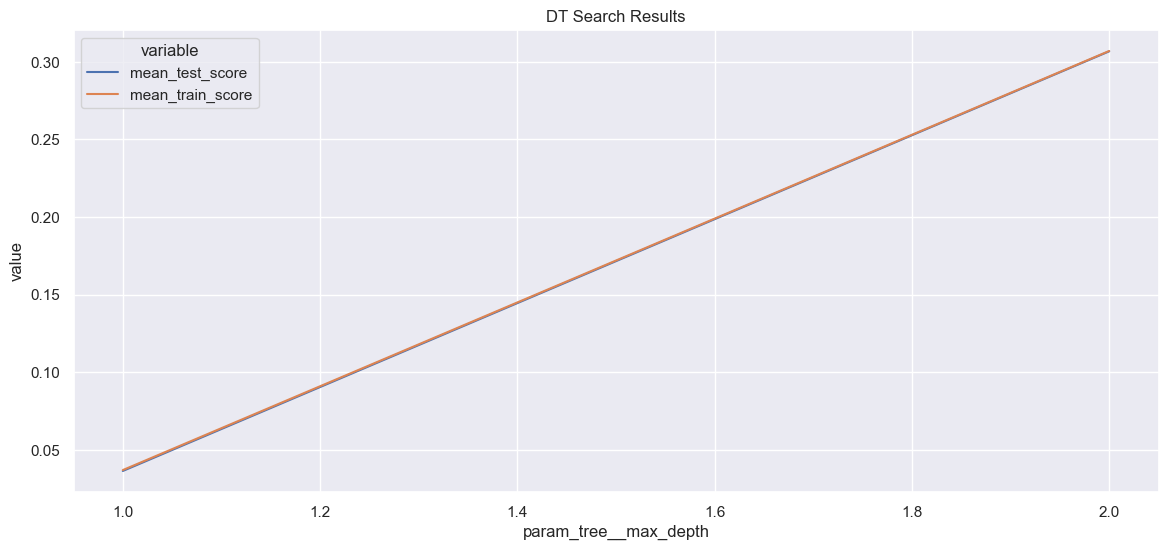

In [48]:
#melt dataframe into long format for seaborn to plot
search_long_1 = search_results_3.melt(id_vars=["param_tree__max_depth"], value_vars=["mean_test_score", "mean_train_score"])

#seaborn plot
plt.figure(figsize=(14, 6))
g = sn.lineplot(data=search_long_1, x="param_tree__max_depth", y="value", hue="variable").set(title='DT Search Results')